In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from contextily import add_basemap
from rasterio import transform, windows
from rasterio.features import rasterize
from shapely import points
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [93]:
S2_URL = (
    "https://storage.googleapis.com/gee-ramiqcom-bucket/mangrove_sofifi/s2_2024_07.tif"
)

S1_URL = (
    "https://storage.googleapis.com/gee-ramiqcom-bucket/mangrove_sofifi/s1_2024_07.tif"
)

SAMPLE_URL = "../data/250204 - Database Riset Mangrove Sofifi Kirim Ramadhan.xlsx"

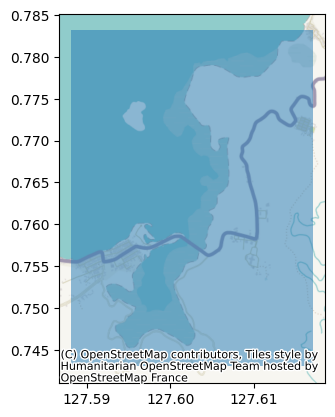

In [192]:
# Boundary
roi = gpd.read_file("../data/Boundary_Mng/Boundary_Mng.shp")
ax = roi.plot(alpha=0.5)
add_basemap(ax=ax, crs="EPSG:4326")

In [195]:
# Create a image mask for image shape (height and width)
# Defined images optimal shape in 30 meter
# 1 degree = 111.000 meter
bounds = tuple(roi.total_bounds)
width = int(abs(bounds[0] - bounds[2]) * 111_000 / 10)
height = int(abs(bounds[1] - bounds[3]) * 111_000 / 10)
shape = (height, width)
print(f"Optimal Shapes: {shape}")


Optimal Shapes: (445, 320)


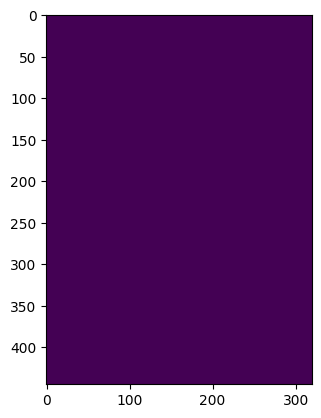

In [196]:
# Create raster of the ROI
transform_roi = transform.from_bounds(*bounds, height=shape[0], width=shape[1])
raster_roi = rasterize(
    [(geometry, 1) for geometry in roi.geometry],
    out_shape=shape,
    fill=0,
    nodata=0,
    transform=transform.from_bounds(*bounds, height=shape[0], width=shape[1]),
    default_value=0,
)
plt.imshow(raster_roi)


In [158]:
# Show sample
sample = pd.read_excel(SAMPLE_URL, sheet_name=4)
sample

,Plot,X,Y,Keterangan,AGC,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,FINAL_NDVI,FINALGNDVI,FINAL_NDI4,FINAL_DVI,FINAL_EVI,FINAL_EVI2,FINAL_SAVI,FINAL_CLRE,FINAL_MCAR,FINAL_IREC
0,1,127.603871,0.757227,Training,237.219760,0.02730,0.02485,0.04970,0.02040,0.09040,0.30880,0.38055,0.3744,0.41090,0.39480,0.09285,0.03515,0.896657,0.765621,0.631769,0.35400,0.675353,0.621768,0.593429,3.14159,0.014936,1.209240
1,2,127.603950,0.757402,Training,121.735748,0.02730,0.02700,0.05550,0.02285,0.09825,0.32275,0.39510,0.3812,0.42835,0.39480,0.09415,0.03520,0.886895,0.745821,0.622626,0.35835,0.680860,0.623851,0.594574,2.87990,0.017230,1.177180
2,3,127.603775,0.757593,Validation,181.384978,0.02485,0.02715,0.05070,0.02325,0.09300,0.28980,0.35025,0.3652,0.38045,0.36475,0.08875,0.03420,0.880293,0.756191,0.600000,0.34195,0.657053,0.601601,0.577326,2.92688,0.015608,1.065560
3,4,127.603752,0.757851,Training,184.386956,0.02485,0.03080,0.05475,0.02575,0.09540,0.27680,0.33145,0.3212,0.35940,0.36475,0.09195,0.03620,0.851564,0.708738,0.574907,0.29545,0.593416,0.534074,0.523260,2.36688,0.018272,0.857239
4,5,127.603764,0.758114,Validation,132.651448,0.02810,0.02900,0.05220,0.02660,0.08970,0.26180,0.30960,0.2996,0.33520,0.32160,0.09790,0.04150,0.836910,0.703241,0.542562,0.27300,0.549650,0.500572,0.495643,2.34002,0.016647,0.796783
5,6,127.603320,0.758512,Training,111.827347,0.02825,0.02925,0.05250,0.02530,0.09020,0.26840,0.32245,0.3148,0.35110,0.32390,0.08860,0.03595,0.851220,0.714130,0.561905,0.28950,0.580288,0.526165,0.516903,2.49002,0.016435,0.861439
6,7,127.603596,0.758666,Training,175.276130,0.02760,0.02900,0.05200,0.02560,0.08650,0.25440,0.30860,0.2920,0.33610,0.31690,0.08620,0.03440,0.838791,0.697674,0.543265,0.26640,0.542301,0.492079,0.488748,2.37572,0.015997,0.783493
7,8,127.603775,0.758481,Training,615.277066,0.02810,0.03060,0.04960,0.02760,0.08570,0.23500,0.28120,0.2668,0.30790,0.32160,0.09160,0.03870,0.812500,0.686473,0.512798,0.23920,0.497132,0.448599,0.451662,2.11319,0.016343,0.655916
8,9,127.604121,0.758465,Training,76.502252,0.02930,0.03360,0.05160,0.03065,0.08540,0.21305,0.25070,0.2424,0.27785,0.29005,0.09685,0.04270,0.775499,0.648980,0.471779,0.21175,0.450801,0.402273,0.410873,1.83841,0.016907,0.528259
9,10,127.604133,0.758657,Validation,108.595516,0.02945,0.03325,0.05160,0.03100,0.08520,0.21285,0.25730,0.2458,0.28290,0.28865,0.09390,0.04055,0.776012,0.652993,0.466437,0.21480,0.454151,0.406757,0.414779,1.88498,0.016458,0.536622


(array([2., 2., 3., 7., 2., 3., 0., 0., 2., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([ 43.67501775,  51.46891199,  59.26280624,  67.05670048,
         74.85059473,  82.64448897,  90.43838321,  98.23227746,
        106.0261717 , 113.82006594, 121.61396019, 129.40785443,
        137.20174867, 144.99564292, 152.78953716, 160.58343141,
        168.37732565, 176.17121989, 183.96511414, 191.75900838,
        199.55290262, 207.34679687, 215.14069111, 222.93458535,
        230.7284796 , 238.52237384, 246.31626809, 254.11016233,
        261.90405657, 269.69795082, 277.49184506]),
 <BarContainer object of 30 artists>)

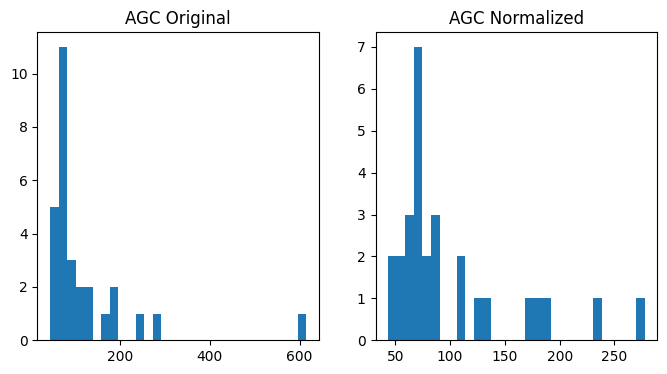

In [159]:
# Sample and normalized
label = "AGC"

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("AGC Original")
plt.hist(sample[label], bins=30)

# Filter sample
mean = sample[label].mean()
std = sample[label].std()
multiplier = 2
mask = (sample[label] >= (mean - (std * multiplier))) & (
    sample[label] <= (mean + (std * multiplier))
)
sample_normal = sample[mask]

plt.subplot(1, 2, 2)
plt.title("AGC Normalized")
plt.hist(sample_normal[label], bins=30)

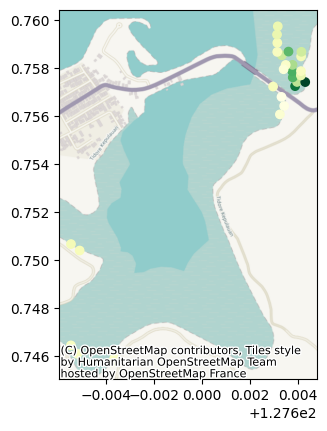

In [160]:
# Make sample ito geodataframe
geometry = points(sample_normal["X"], sample_normal["Y"])
sample_normal = gpd.GeoDataFrame(sample_normal, geometry=geometry, crs="EPSG:4326")

ax = sample_normal.plot(column="AGC", cmap="YlGn")
add_basemap(ax=ax, crs="EPSG:4326")

In [161]:
indices = [
    dict(name="NDMI", band1="NIR", band2="SWIR1", cmap="RdYlGn"),
    dict(name="NBR", band1="NIR", band2="SWIR2", cmap="RdYlGn"),
    dict(name="NBR2", band1="SWIR1", band2="SWIR2", cmap="RdYlGn"),
    dict(name="NDWI", band1="GREEN", band2="NIR", cmap="RdBu"),
    dict(name="MNDWI", band1="GREEN", band2="SWIR1", cmap="RdBu"),
    dict(name="MNDWI2", band1="GREEN", band2="SWIR2", cmap="RdBu"),
    dict(name="NDVI", band1="NIR", band2="RED", cmap="RdYlGn"),
    dict(name="NDTI", band1="RED", band2="GREEN", cmap="Reds"),
    dict(name="GNDVI", band1="NIR", band2="GREEN", cmap="RdYlGn"),
    dict(name="NDI45", band1="RE1", band2="RED", cmap="RdYlGn"),
]
band_map_s2 = dict(
    COASTAl=0,
    BLUE=1,
    GREEN=2,
    RED=3,
    RE1=4,
    RE2=5,
    RE3=6,
    NIR=7,
    RE4=8,
    WV=9,
    SWIR1=10,
    SWIR2=11,
)

In [163]:
# Sample images
extract = sample_normal.copy()[["AGC", "Keterangan"]]
coords = [coord for coord in zip(sample_normal.geometry.x, sample_normal.geometry.y)]

# Bands
bands_s2 = [
    "COASTAL",
    "BLUE",
    "GREEN",
    "RED",
    "RE1",
    "RE2",
    "RE3",
    "NIR",
    "RE4",
    "WV",
    "SWIR1",
    "SWIR2",
]

bands_s1 = ["VV", "VH"]

with rio.open(S2_URL) as source:
    extract[bands_s2] = [data for data in source.sample(coords)]

with rio.open(S1_URL) as source:
    extract[bands_s1] = [data for data in source.sample(coords)]

# Filter sample
extract = extract[(extract["BLUE"] != -9999) & (extract["VV"] != -9999)]

extract[bands_s2] = extract[bands_s2] / 1e4
extract[bands_s1] = extract[bands_s1] / 1e3

# Calculate indices
for x in range(len(indices)):
    index = indices[x]
    name = index["name"]
    band1 = index["band1"]
    band2 = index["band2"]

    extract[name] = (extract[band1] - extract[band2]) / (
        extract[band1] + extract[band2]
    )

# Calculate other custom indices
extract["DVI"] = extract["NIR"] - extract["RED"]
extract["EVI"] = (
    2.5
    * (extract["NIR"] - extract["RED"])
    / (extract["NIR"] + 6 * extract["RED"] - 7.5 * extract["BLUE"] + 1)
)
extract["EVI2"] = (
    2.5
    * (extract["NIR"] - extract["RED"])
    / (extract["NIR"] + 2.4 * extract["RED"] + 1)
)
extract["SAVI"] = (
    1.5 * (extract["NIR"] - extract["RED"]) / (extract["NIR"] + extract["RED"] + 0.5)
)
extract["CLRE"] = (extract["NIR"] / extract["RE1"]) - 1
extract["MCARI"] = (
    ((extract["RE1"] - extract["RED"]) - (0.2 * extract["RE1"] - extract["GREEN"]))
    * extract["RE1"]
    / extract["NIR"]
)
extract["IRECI"] = (extract["NIR"] - extract["RED"]) / (extract["RE1"] / extract["RE2"])
extract["RVI"] = (4 * extract["VH"]) / (extract["VV"] / extract["VH"])

# Filter only mangrove like
extract = extract[(extract["NDMI"] > 0.5) & (extract["NDWI"] < 0)]

extract

,AGC,Keterangan,COASTAL,BLUE,GREEN,RED,RE1,RE2,RE3,NIR,RE4,WV,SWIR1,SWIR2,VV,VH,NDMI,NBR,NBR2,NDWI,MNDWI,MNDWI2,NDVI,NDTI,GNDVI,NDI45,DVI,EVI,EVI2,SAVI,CLRE,MCARI,IRECI,RVI
0,237.219760,Training,0.0179,0.0224,0.0388,0.0160,0.0737,0.2798,0.3589,0.3558,0.3873,0.3711,0.0816,0.0284,-4.966,-14.349,0.626886,0.852160,0.483636,-0.803345,-0.355482,0.154762,0.913932,-0.416058,0.803345,0.643255,0.3398,0.661707,0.609310,0.584652,3.827680,0.016936,1.290041,-165.842772
1,121.735748,Training,0.0179,0.0251,0.0445,0.0170,0.0834,0.3059,0.3843,0.3740,0.4126,0.3711,0.0837,0.0281,-5.997,-13.050,0.634258,0.860234,0.497317,-0.787336,-0.305772,0.225895,0.913043,-0.447154,0.787336,0.661355,0.3570,0.693069,0.630831,0.601010,3.484412,0.021011,1.309428,-113.591796
2,181.384978,Validation,0.0168,0.0228,0.0443,0.0165,0.0774,0.2770,0.3462,0.3617,0.3754,0.3486,0.0773,0.0270,-7.043,-14.303,0.647836,0.861075,0.482263,-0.781773,-0.271382,0.242637,0.912745,-0.457237,0.781773,0.648562,0.3452,0.669148,0.615857,0.589615,3.673127,0.019199,1.235406,-116.186744
3,184.386956,Training,0.0168,0.0250,0.0456,0.0185,0.0790,0.2614,0.3203,0.3217,0.3438,0.3486,0.0777,0.0274,-8.025,-14.542,0.610916,0.843025,0.478592,-0.751702,-0.260341,0.249315,0.891240,-0.422777,0.751702,0.620513,0.3032,0.608738,0.554864,0.541300,3.072152,0.022175,1.003247,-105.405490
4,132.651448,Validation,0.0179,0.0252,0.0450,0.0212,0.0775,0.2507,0.3075,0.2964,0.3312,0.3070,0.0821,0.0322,-5.390,-13.933,0.566182,0.804017,0.436570,-0.736380,-0.291896,0.165803,0.866499,-0.359517,0.736380,0.570415,0.2752,0.557266,0.510659,0.504892,2.824516,0.022434,0.890228,-144.065669
5,111.827347,Training,0.0179,0.0237,0.0403,0.0184,0.0764,0.2586,0.3215,0.3104,0.3433,0.3070,0.0758,0.0269,-7.636,-12.123,0.607457,0.840498,0.476144,-0.770174,-0.305771,0.199405,0.888078,-0.373083,0.770174,0.611814,0.2920,0.587265,0.538920,0.528475,3.062827,0.020434,0.988366,-76.986448
6,175.276130,Training,0.0183,0.0245,0.0419,0.0197,0.0747,0.2477,0.3055,0.2939,0.3281,0.3095,0.0749,0.0267,-5.988,-12.015,0.593818,0.833437,0.474409,-0.750447,-0.282534,0.221574,0.874362,-0.360390,0.750447,0.582627,0.2742,0.558066,0.511117,0.505531,2.934404,0.020832,0.909228,-96.433016
10,67.701120,Validation,0.0161,0.0206,0.0403,0.0166,0.0740,0.2540,0.3147,0.3416,0.3454,0.3576,0.0870,0.0311,-6.251,-12.885,0.594027,0.833110,0.473328,-0.788950,-0.366850,0.128852,0.907314,-0.416520,0.788950,0.633554,0.3250,0.631460,0.588154,0.568049,3.616216,0.017958,1.115541,-106.237866
11,66.756794,Training,0.0213,0.0256,0.0450,0.0188,0.0734,0.2696,0.3380,0.3447,0.3652,0.3698,0.0811,0.0308,-6.864,-12.198,0.619070,0.835952,0.449508,-0.769053,-0.286281,0.187335,0.896561,-0.410658,0.769053,0.592191,0.3259,0.643817,0.586227,0.566126,3.696185,0.018083,1.197039,-86.708161
12,73.191605,Training,0.0216,0.0221,0.0395,0.0149,0.0713,0.3073,0.3960,0.3817,0.4236,0.3939,0.0917,0.0324,-6.429,-13.075,0.612590,0.843516,0.477840,-0.812441,-0.397866,0.098748,0.924861,-0.452206,0.812441,0.654292,0.3668,0.702494,0.646932,0.613652,4.353436,0.015250,1.580893,-106.365298


Correlation between AGB and bands sorted by the highest


,band,r2
12,VV,0.174
31,RVI,0.083
16,NBR2,0.074
15,NBR,0.072
11,SWIR2,0.065
13,VH,0.059
1,BLUE,0.049
14,NDMI,0.042
19,MNDWI2,0.039
21,NDTI,0.028


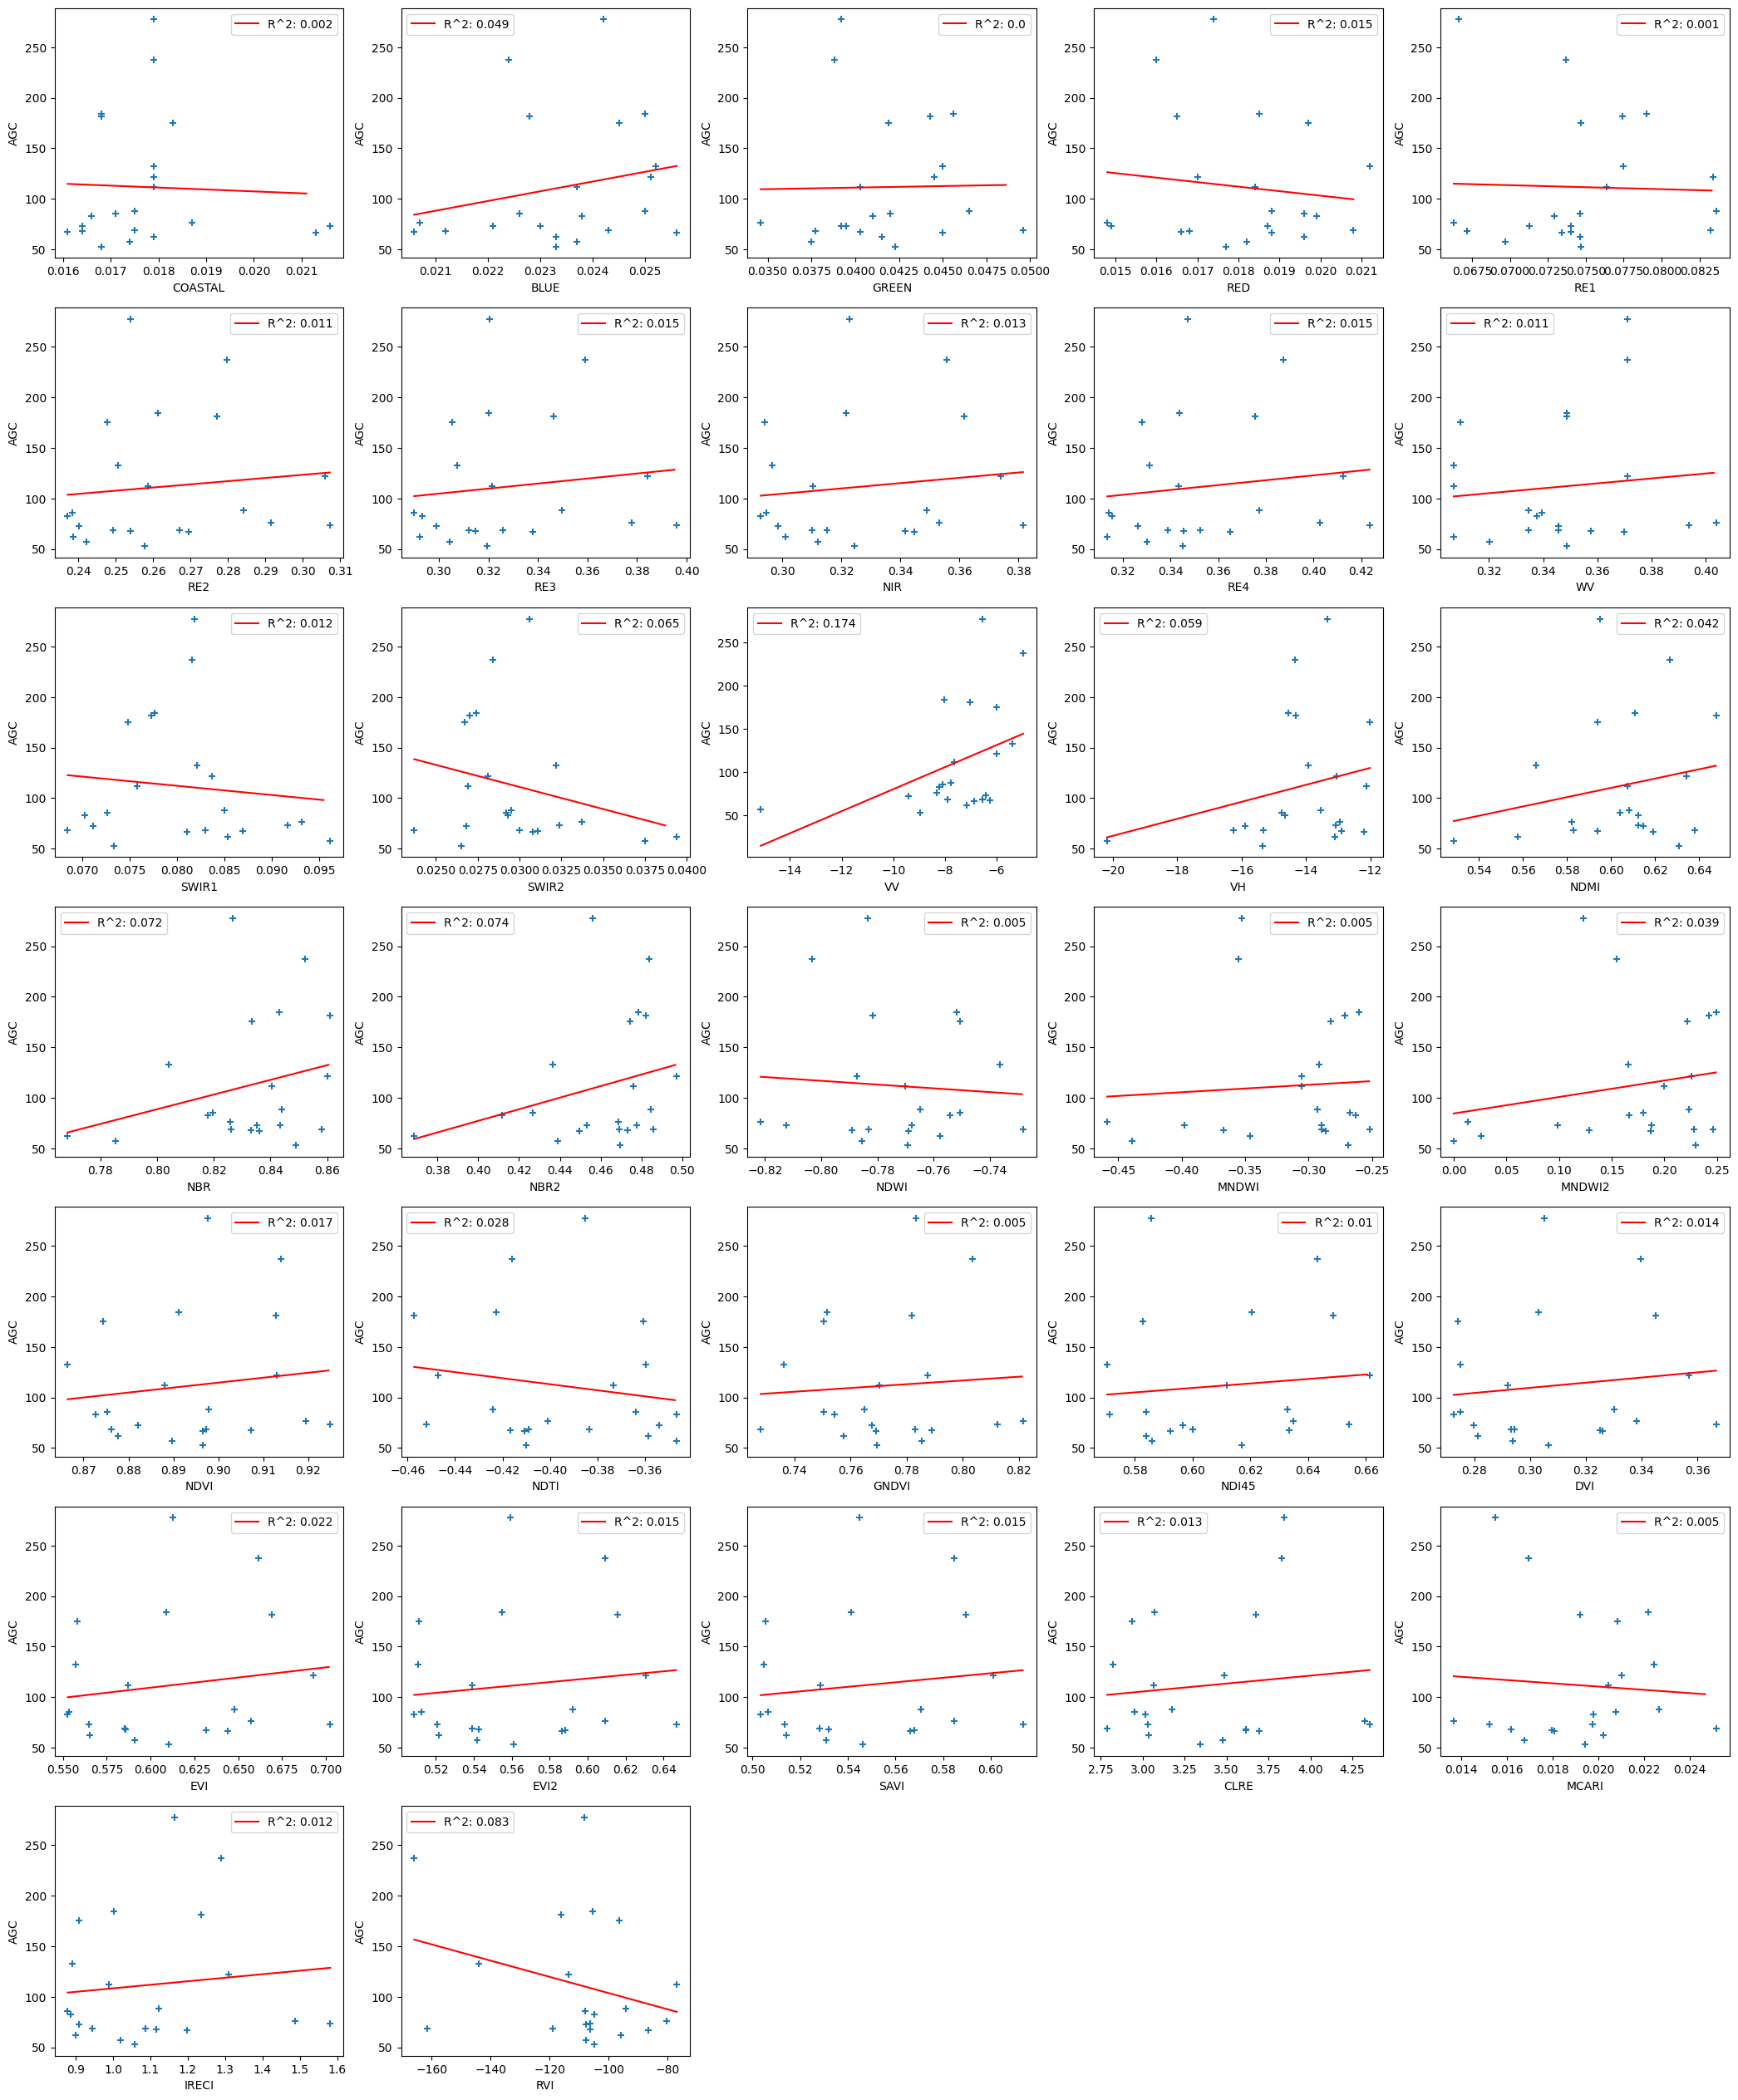

In [174]:
# Calculate the R2 correlation per bands
# Plot correlation between AGB and variables/features

# Correlate between band and label
label = "AGC"
bands = extract.columns[2:]

# List of features and its correlation ** 2
features_corr = []

plt.figure(figsize=(26, 32))
for x in range(len(bands)):
    band = bands[x]
    sample_band = extract[bands[x]]

    # Calculate stddev and mean
    std_dev = np.std(sample_band)
    mean = np.mean(sample_band)

    # Outlier mask
    filter_multiplier = 10
    mask = (sample_band > (mean - std_dev * filter_multiplier)) & (
        sample_band < (mean + std_dev * filter_multiplier)
    )

    # Only use normalized data
    sample_band = sample_band[mask]
    sample_label = extract[label][mask]

    # Calculate trend
    poly = 1
    trend = np.polyfit(sample_band, sample_label, poly)
    predict = np.poly1d(trend)

    # Min max
    min_x = np.min(sample_band)
    max_x = np.max(sample_band)

    # Make trendline
    trend_x = np.arange(min_x, max_x, 0.001)
    trend_y = predict(trend_x)

    # Calculate R2
    r2 = round(np.corrcoef(sample_label, predict(sample_band))[0, 1] ** 2, 3)

    # Append it to list
    features_corr.append(dict(band=band, r2=r2))

    plt.subplot(7, 5, x + 1)
    plt.scatter(sample_band, sample_label, marker="+")
    plt.xlabel(band)
    plt.ylabel(label)
    plt.plot(trend_x, trend_y, color="red", label=f"R^2: {r2}")
    plt.legend()

# Make list into dataframe
features_corr = pd.DataFrame(features_corr).sort_values("r2", ascending=False)
print("Correlation between AGB and bands sorted by the highest")
features_corr

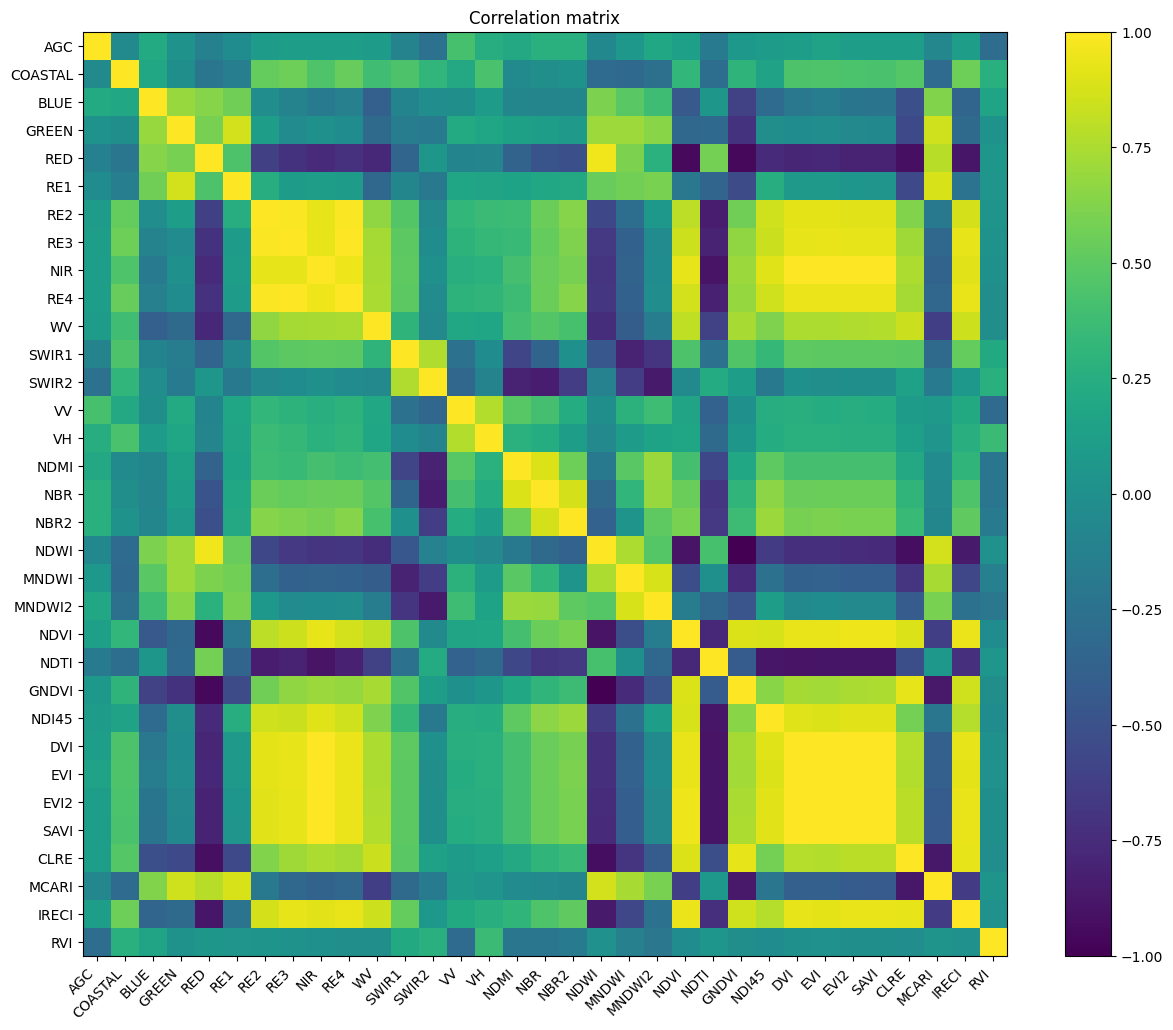

In [175]:
# Correlation matrix between features
corr = extract[["AGC", *list(extract.columns[2:])]].corr()
plt.figure(figsize=(15, 12))
plt.title("Correlation matrix")
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr)), corr.columns)
plt.show()


In [176]:
# Split into train and test
train = extract[extract["Keterangan"] == "Training"]
test = extract[extract["Keterangan"] == "Validation"]

In [182]:
# Create model
model = RandomForestRegressor(n_estimators=100)

# Predictors
predictors = ["SWIR1", "SWIR2", "RVI"]

# Train model
model.fit(train[predictors], train[label])

pd.DataFrame(
    dict(importance=model.feature_importances_, features=predictors)
).sort_values("importance", ascending=False)

,importance,features
2,0.44515,RVI
0,0.28169,SWIR1
1,0.27316,SWIR2


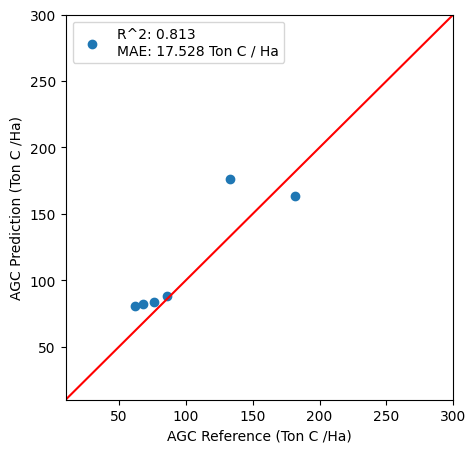

In [183]:
# Test the model
test_apply = model.predict(test[predictors])
test_reference = test[label]

# Calculate R2
r2 = round(np.corrcoef(test_reference, test_apply)[0, 1] ** 2, 3)
mae = round(mean_absolute_error(test_reference, test_apply), 3)

# Plot 1:1
plt.figure(figsize=(5, 5))
plt.scatter(
    test_reference,
    test_apply,
    label=f"R^2: {r2}\nMAE: {mae} Ton C / Ha",
)
plt.plot([-2000, 2000], [-2000, 2000], color="red")
plt.xlim(10, 300)
plt.ylim(10, 300)
plt.xlabel("AGC Reference (Ton C /Ha)")
plt.ylabel("AGC Prediction (Ton C /Ha)")
plt.legend()
plt.show()

In [197]:
# Apply model
# Create the image first

with rio.open(S2_URL) as source:
    window = windows.from_bounds(*bounds, transform=source.transform)
    image_s2 = source.read([3, 8, 11, 12], out_dtype="float32", window=window)
    image_s2[image_s2 == source.nodata] = np.nan

    ndmi = (image_s2[1] - image_s2[2]) / (image_s2[1] + image_s2[2])
    ndwi = (image_s2[0] - image_s2[1]) / (image_s2[0] + image_s2[1])

    image_s2 = image_s2[2:] / 1e4


with rio.open(S1_URL) as source:
    image_s1 = source.read(out_dtype="float32", window=window)
    image_s1[image_s1 == source.nodata] = np.nan
    image_s1 = image_s1 / 1e3
    rvi = 4 * image_s1[1] / (image_s1[0] + image_s1[1])

images_all = np.concatenate([image_s2, [rvi, ndmi, ndwi]], 0)
table_image = pd.DataFrame(
    images_all.transpose(1, 2, 0).reshape(-1, images_all.shape[0]),
    columns=[*predictors, "NDMI", "NDWI"],
)
valid_mask = ~np.isnan(table_image["SWIR1"]) & ~np.isnan(table_image["RVI"])
mangrove_mask = (table_image["NDMI"] > 0.5) & (table_image["NDWI"] < 0)
table_mask = table_image[valid_mask & mangrove_mask]
table_mask

,SWIR1,SWIR2,RVI,NDMI,NDWI
2553,0.0684,0.0322,2.565140,0.519494,-0.651145
2554,0.0684,0.0322,2.708236,0.531025,-0.670782
2875,0.0684,0.0322,2.563288,0.505065,-0.658692
2876,0.0684,0.0322,2.651618,0.538773,-0.669960
3514,0.0365,0.0201,2.220752,0.537096,-0.496296
...,...,...,...,...,...
136686,0.1727,0.0670,2.436563,0.512009,-0.788735
137007,0.1747,0.0684,2.622660,0.505379,-0.805126
137329,0.1717,0.0674,2.695518,0.507600,-0.788704
140604,0.1886,0.0797,2.413124,0.530262,-0.783454


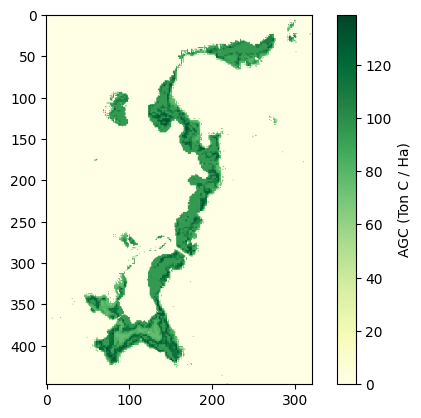

In [201]:
# Predict image
prediction = model.predict(table_mask[predictors])
table_image.loc[valid_mask & mangrove_mask, label] = prediction
table_image.loc[~valid_mask | ~mangrove_mask, label] = -9999
prediction = (
    table_image[label].to_numpy().reshape(images_all.shape[1], images_all.shape[2])
)

plt.imshow(prediction, cmap="YlGn", vmin=0)
plt.colorbar(label="AGC (Ton C / Ha)")

In [203]:
# Save it
with rio.open(
    "AGC_2024_07.tif",
    "w",
    "COG",
    count=1,
    width=prediction.shape[1],
    height=prediction.shape[0],
    compress="zstd",
    crs="EPSG:4326",
    transform=transform_roi,
    dtype="int16",
    nodata=-9999,
    resampling="bilinear",
) as output:
    output.write(prediction, 1)
    output.set_band_description(1, "AGC")